In [1]:
import os

path = 'lastfm-dataset-1K'

if not os.path.exists(path):

  !wget http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
  !tar -xvzf lastfm-dataset-1K.tar.gz


--2021-05-30 14:38:35--  http://mtg.upf.edu/static/datasets/last.fm/lastfm-dataset-1K.tar.gz
Resolving mtg.upf.edu (mtg.upf.edu)... 84.89.139.55
Connecting to mtg.upf.edu (mtg.upf.edu)|84.89.139.55|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672741554 (642M) [application/x-gzip]
Saving to: ‘lastfm-dataset-1K.tar.gz’

lastfm-dataset-1K.t 100%[===================>] 641.58M  2.00MB/s    in 5m 47s  

2021-05-30 14:44:22 (1.85 MB/s) - ‘lastfm-dataset-1K.tar.gz’ saved [672741554/672741554]

lastfm-dataset-1K/
lastfm-dataset-1K/userid-profile.tsv
lastfm-dataset-1K/README.txt
lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv


In [2]:
!ls

lastfm-dataset-1K  lastfm-dataset-1K.tar.gz  sample_data


In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/data

feature_df_with_emb.csv  spotify_features.csv


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sp
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import matplotlib.pyplot as plt
import matplotlib
mpl.style.use('seaborn')
%matplotlib inline

import datetime
import time 
import math
import os
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.


In [176]:
path = "drive/MyDrive/data/feature_df_with_emb.csv"

feature_df_with_emb = pd.read_csv(path)
feature_df_with_emb = feature_df_with_emb.drop('Unnamed: 0')

KeyError: ignored

In [ ]:
feature_df_with_emb.head()

In [8]:
# Load the dataset
df = pd.read_table('lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv', lineterminator='\n', warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
df_profile = pd.read_csv('lastfm-dataset-1K/userid-profile.tsv', sep='\t', error_bad_lines=False, warn_bad_lines=True, skiprows=1, names=['user', 'gender', 'age', 'country', 'signup'])

In [9]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [10]:
# Get rows with song names containing multiple rows
duplicated = df.loc[df['song-id'].isin(grouped[grouped['song'] > 1].index)]
duplicated = duplicated.drop(columns=['user', 'timestamp', 'artist', 'artist-id'])
containis_extra_rows = duplicated.apply(lambda x: pd.Series({'id': x[0], 'song': x[1], 'flag':'\n' in x[1]}), axis=1)
containis_extra_rows = containis_extra_rows.loc[containis_extra_rows['flag']]

In [11]:
# Iterate over those 5k rows to get the extra rows and correct the song name
for index, row in containis_extra_rows.iterrows():
    row_break = row['song'].split('\n', 1)
    song_name = row_break[0]
    df.loc[df['song-id'] == row['id'], 'song'] = song_name
    
    tsv = StringIO(row_break[1])
    df_extra = pd.read_csv(tsv, sep="\t", warn_bad_lines=True, names=['user', 'timestamp', 'artist-id', 'artist', 'song-id', 'song'])
    df = df.append(df_extra, ignore_index=True)

### Fix names

In [12]:
# Check if some songs share a common ID
grouped = df[['song-id', 'song']].groupby(['song-id']).nunique()

In [13]:
# Check how many ids has more than 1 song name
grouped[grouped['song'] > 1].shape[0]

200

In [14]:
ids_to_be_fixed = grouped[grouped['song'] > 1].index

In [15]:
df = df.set_index('song-id')

In [16]:
map_to_fix = df.groupby(df.index)['song'].head(1)

In [17]:
df.loc[ids_to_be_fixed, 'song'] = df.loc[ids_to_be_fixed].reset_index()['song-id'].map(lambda x: map_to_fix[x])
df = df.reset_index()

### Create matrix

In [161]:
matrix_init = df.groupby(['user', 'artist', 'song']).count()

In [162]:
matrix_init = matrix_init['timestamp']
matrix_init = matrix_init.map(lambda x: np.log(x))

In [163]:
matrix_init = matrix_init.reset_index()

In [165]:
def rating_scaler(row):
    row_array = np.array(row)
    lower_bound, new_range= 2, 5
    min_, max_ = row_array.min(), row_array.max()
    old_range = max_ - min_
    
    
    scaled_row = (new_range * (row_array - min_)) / (old_range + 1e-6)  + lower_bound
    scaled_row[scaled_row == 2] = 0
    return pd.Series(scaled_row)

In [166]:
matrix_init_scaled = matrix_init.groupby('user')['timestamp'].apply(rating_scaler)

In [167]:
matrix_init['timestamp'] = matrix_init_scaled.reset_index()['timestamp']

In [168]:
matrix_init['timestamp'].describe()

count    4.613822e+06
mean     1.937737e+00
std      1.952554e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.669559e+00
75%      3.572332e+00
max      6.999999e+00
Name: timestamp, dtype: float64

In [169]:
(matrix_init['timestamp'] == 0).sum() / matrix_init.shape[0]

0.47684197613171897

In [132]:
feature_df_with_emb.head()
feature_df_with_emb['item'] = feature_df_with_emb.apply(lambda row: row[1]+'-'+row[2], axis=1)

### Merge data

In [170]:
matrix_init = matrix_init.rename({'timestamp':'rating', 'song':'track'}, axis=1)

In [171]:
matrix_extended = matrix_init.merge(feature_df_with_emb, on=['artist', 'track'])

In [172]:
matrix_extended.head()

,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z,item
0,user_000001,2562,Basin Dub,2.815756,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
1,user_000451,2562,Basin Dub,2.772113,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
2,user_000471,2562,Basin Dub,0.000000,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
3,user_000508,2562,Basin Dub,3.411437,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub
4,user_000515,2562,Basin Dub,2.695427,1056,0.644,0.431,11.0,-7.676,1.0,0.206,0.0393,0.3,0.159,0.347,139.998,292769.0,"['classic dubstep', 'future garage', 'bass mus...",19,[5.3110935 6.1038699 3.31327275],5.311094,6.10387,3.313273,2562-Basin Dub


### Filter the dataset

In [136]:
matrix_extended.groupby('user').count()['rating'].describe()

count      992.000000
mean      4367.426411
std       5152.289753
min          1.000000
25%       1265.500000
50%       2945.000000
75%       5524.500000
max      65246.000000
Name: rating, dtype: float64

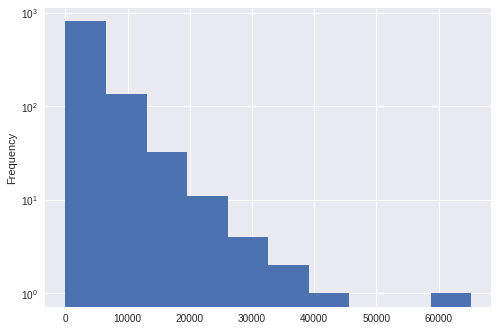

In [137]:
matrix_extended.groupby('user').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [138]:
matrix_extended.groupby('item').count()['rating'].describe()

count    929536.000000
mean          4.660914
std          10.819621
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max         346.000000
Name: rating, dtype: float64

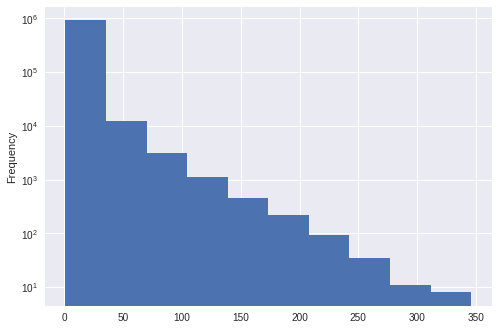

In [139]:
matrix_extended.groupby('item').count()['rating'].plot.hist()
plt.yscale('log')
plt.show()

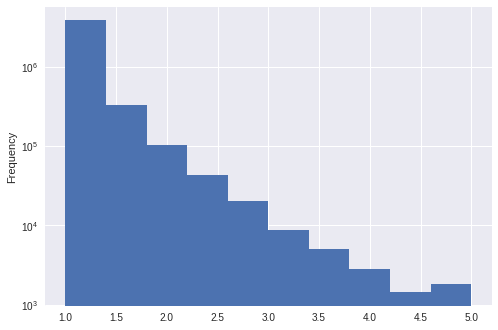

In [140]:
matrix_extended['rating'].plot.hist()
plt.yscale('log')
plt.show()

In [141]:
items_app = matrix_extended.groupby('item').count()['rating']
items_app = items_app.loc[items_app > 3.99].index
matrix_sampled = matrix_extended.copy()
matrix_sampled = matrix_sampled.set_index('item')
matrix_sampled = matrix_sampled.loc[items_app]
matrix_sampled = matrix_sampled.reset_index()
matrix_sampled = matrix_sampled.sample(frac=1)

In [142]:
matrix_sampled.groupby('user').count()['rating'].describe()

count      991.000000
mean      3399.972755
std       3809.005245
min          3.000000
25%       1064.500000
50%       2344.000000
75%       4265.000000
max      47788.000000
Name: rating, dtype: float64

### Sample Users

In [143]:
# no_users = 200
# users_list = matrix_extended.user.unique()
# users_sampled = np.random.choice(users_list, replace=False, size=no_users)
# matrix_sampled = matrix_extended.copy()
# matrix_sampled = matrix_sampled.set_index('user')
# matrix_sampled = matrix_sampled.loc[users_sampled]
# matrix_sampled = matrix_sampled.reset_index()
# matrix_sampled = matrix_sampled.sample(frac=1)
# matrix_sampled['item'] = matrix_sampled.apply(lambda row: row[1]+'-'+row[2], axis=1)

In [144]:
matrix_sampled.head()

,item,user,artist,track,rating,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genres,popularity,genres_emb,emb_x,emb_y,emb_z
387290,Blur-Girls And Boys,user_000767,Blur,Girls And Boys,1.139130,8207,0.693,0.875,7.0,-8.354,0.0,0.0315,0.00971,0.000000,0.0601,0.901,120.048,259387.0,"['britpop', 'rock', 'permanent wave', 'modern ...",73,[5.608908 7.75983145 1.4612413 ],5.608908,7.759831,1.461241
2675319,The Auteurs-Junk Shop Clothes,user_000826,The Auteurs,Junk Shop Clothes,1.000000,205597,0.578,0.388,0.0,-10.260,1.0,0.0289,0.04120,0.000007,0.0828,0.216,139.880,162667.0,['britpop'],30,"(5.596067, 7.7830863, 1.518607)",5.596067,7.783086,1.518607
2011040,Omnium Gatherum-Into Sea,user_000344,Omnium Gatherum,Into Sea,1.444444,448304,0.501,0.956,2.0,-4.263,1.0,0.1160,0.00002,0.003250,0.3560,0.169,103.965,216293.0,"['melodic death metal', 'finnish death metal',...",42,[ 8.2620405 8.84846 -0.69622282],8.262041,8.848460,-0.696223
33340,A.C. Newman-On The Table,user_000865,A.C. Newman,On The Table,1.000000,7487,0.688,0.933,4.0,-4.340,1.0,0.0348,0.26500,0.000272,0.3750,0.961,121.057,237907.0,['vancouver indie'],35,"(5.596391, 8.277806, 1.4727577)",5.596391,8.277806,1.472758
1142043,Green Carnation-Maybe?,user_000581,Green Carnation,Maybe?,1.169014,41890,0.320,0.434,2.0,-9.870,1.0,0.0267,0.31800,0.258000,0.1040,0.126,101.348,302920.0,"['norwegian metal', 'norwegian prog', 'progres...",32,[ 7.93799535 8.9379495 -0.3131807 ],7.937995,8.937950,-0.313181


In [145]:
matrix_sampled['user_id'] = matrix_sampled['user'].astype('category').cat.codes
matrix_sampled['item_id'] = matrix_sampled['item'].astype('category').cat.codes

In [146]:
X = matrix_sampled[['user_id', 
              'item_id',
              'danceability',
              'energy',
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness',
              'valence', 
              'tempo', 
              'popularity', 
              'emb_x', 
              'emb_y',
              'emb_z']]
y = matrix_sampled['rating']
groups = matrix_sampled['user_id']

In [147]:
# Change splitting to be by index using https://stackoverflow.com/questions/53490497/getting-validation-set-from-train-set-by-using-percentage-from-groupby-in-pand
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=groups)

In [148]:
no_users, no_items, no_factors = matrix_sampled['user_id'].nunique(), matrix_sampled['item_id'].nunique(), 100

In [149]:
no_users

991

In [150]:
no_items

246166

### Models

In [151]:
def create_shallow_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Dot product 
    vectors_product = tf.keras.layers.dot([user_vector, item_vector], axes=1, normalize=False)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[vectors_product], name='shallow_model')
    return model

In [152]:
model = create_shallow_model(no_factors, no_users, no_items)

In [153]:
model.summary()

Model: "shallow_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_matrix (Embedding)         (None, 1, 100)       99200       user_id[0][0]                    
__________________________________________________________________________________________________
item_matrix (Embedding)         (None, 1, 100)       24616700    item_id[0][0]                    
______________________________________________________________________________________

In [154]:
def create_deep_model(no_factors, no_users, no_items):
    # User branch
    user_id = tf.keras.layers.Input(shape=[1], name='user_id')
    user_matrix = tf.keras.layers.Embedding(no_users+1, no_factors, name='user_matrix')(user_id)
    user_vector = tf.keras.layers.Flatten(name='user_vector')(user_matrix)
    # Item branch
    item_id = tf.keras.layers.Input(shape=[1], name='item_id')
    item_matrix = tf.keras.layers.Embedding(no_items+1, no_factors, name='item_matrix')(item_id)
    item_vector = tf.keras.layers.Flatten(name='item_vector')(item_matrix)
    # Concantenation
    vectors_concat = tf.keras.layers.Concatenate()([user_vector, item_vector])
    vectors_concat_dropout = tf.keras.layers.Dropout(0.2)(vectors_concat)
    # Backbone 
    dense_1 = tf.keras.layers.Dense(64,name='fc3')(vectors_concat_dropout)
    dropout_1 = tf.keras.layers.Dropout(0.2,name='d3')(dense_1)
    dense_2 = tf.keras.layers.Dense(32,name='fc4', activation='relu')(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.2,name='d4')(dense_2)
    dense_3 = tf.keras.layers.Dense(16,name='fc5', activation='relu')(dropout_2)
    dropout_3 = tf.keras.layers.Dropout(0.2,name='d5')(dense_3)
    dense_4 = tf.keras.layers.Dense(8,name='fc6', activation='relu')(dropout_3)
    dense_4_output = tf.keras.layers.Dense(1, activation='relu', name='activation')(dense_4)
    # Model definition
    model = tf.keras.models.Model(inputs=[user_id, item_id], outputs=[dense_4_output], name='deep_model')
    return model

In [155]:
model = create_deep_model(no_factors, no_users, no_items)

### Model training

In [156]:
# Input-output data definition
X_train_arr = [X_train.user_id, X_train.item_id]

# Model creation
model = create_deep_model(no_factors, no_users, no_items)

# Model compiling 
model.compile(loss=tf.keras.losses.MeanSquaredError())

# Model training
model.fit(X_train_arr, y_train, epochs=10, batch_size=2048, shuffle=True)

Epoch 1/10
1317/1317 [==============================] - 128s 97ms/step - loss: 0.1338
Epoch 2/10
1317/1317 [==============================] - 127s 97ms/step - loss: 0.0999
Epoch 3/10
1317/1317 [==============================] - 127s 97ms/step - loss: 0.0977
Epoch 4/10
1317/1317 [==============================] - 127s 97ms/step - loss: 0.0958
Epoch 5/10
1317/1317 [==============================] - 127s 96ms/step - loss: 0.0947
Epoch 6/10
 729/1317 [===============>..............] - ETA: 56s - loss: 0.0930

KeyboardInterrupt: ignored

### Prediction

In [ ]:
# Predictions in the training set
# X_train = [X_train.user_id, X_train.item_id]
y_train_pred = model.predict(X_train_arr, batch_size=2048)

In [ ]:
X_test.head()

In [ ]:
# Predictions in the test set
X_test_arr = [X_test.user_id, X_test.item_id]
y_test_pred = model.predict(X_test_arr, batch_size=2048)

### Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
print('Train RMSE:', mean_squared_error(y_train.values, y_train_pred, squared=False))
print('Test RMSE:', mean_squared_error(y_test.values, y_test_pred, squared=False))

In [ ]:
def get_test_predictions(model, test_ratings):
  predictions_li = []
  for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id'), position=0, leave=True):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        irrelevant_pids = set(test_pids).difference(relevant_pids)
        predictions_relevant = predictions[user_df['rating'] > 1]
        predictions_irrelevant = predictions[user_df['rating'] == 1]
        predictions_dict = {'user_id': user_id,
                            'predictions': predictions,
                            'test_pids': test_pids,
                            'relevant_pids': relevant_pids,
                            'irrelevant_pids': irrelevant_pids,
                            'predictions_relevant': predictions_relevant,
                            'predictions_irrelevant': predictions_irrelevant}
        predictions_li.append(predictions_dict)

  return pd.DataFrame(predictions_li)


In [ ]:
X_test_arr = np.array(X_test_arr)
test_ratings = pd.DataFrame({'user_id': X_test_arr[0, :], 'item_id':X_test_arr[1, :], 'rating': y_test})
predictions_df = get_test_predictions(model, test_ratings)

In [ ]:
# Predictions analysis (Used to debug the recommender system prediction range)
predictions_df['mean'] = predictions_df['predictions'].map(lambda a: a.mean())
predictions_df['median'] = predictions_df['predictions'].map(lambda a:np.median(a))
predictions_df['min'] = predictions_df['predictions'].map(lambda a: a.min())
predictions_df['max'] = predictions_df['predictions'].map(lambda a: a.max())
predictions_df['25th'] = predictions_df['predictions'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th'] = predictions_df['predictions'].map(lambda a: np.percentile(a, q=75))
# Predictions relevant analysis (Used to debug the recommender system prediction range)
predictions_df['mean_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.mean())
predictions_df['median_relevant'] = predictions_df['predictions_relevant'].map(lambda a:np.median(a))
predictions_df['min_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.min())
predictions_df['max_relevant'] = predictions_df['predictions_relevant'].map(lambda a: a.max())
predictions_df['25th_relevant'] = predictions_df['predictions_relevant'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th_relevant'] = predictions_df['predictions_relevant'].map(lambda a: np.percentile(a, q=75))
# Predictions irrelevant analysis (Used to debug the recommender system prediction range)
predictions_df['mean_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.mean())
predictions_df['median_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a:np.median(a))
predictions_df['min_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.min())
predictions_df['max_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: a.max())
predictions_df['25th_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: np.percentile(a, q=25))
predictions_df['75th_irrelevant'] = predictions_df['predictions_irrelevant'].map(lambda a: np.percentile(a, q=75))

In [ ]:
import seaborn as sns
import matplotlib as mpl

def plot_predictions(predictions_df):
  pred_arr = [predictions_df[['predictions_relevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1),
              predictions_df[['predictions_irrelevant']].apply(lambda x: np.hstack(x), axis=0).values.reshape(-1)]

  f, ax = plt.subplots(1, 1)
  ax.set_title('Predictions distribution', color='C0')
  c = 'red'
  bplot = plt.boxplot(pred_arr, labels=['Relevant', 'Irrelevant'], vert=True, patch_artist=True)
  # fill with colors
  colors = ['C4', 'C2']
  for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

  for median in bplot['medians']:
    median.set(color='k', linewidth=1.5)

  plt.show()

In [ ]:
plot_predictions(predictions_df)

In [120]:
def precision_at_k(user_test):
    precisions = []
    # For each user
    for user_id, predictions in tqdm(predictions_df):
      
      # Sort the items and het the top k
      top_k = predictions > 1.1
      top_k_items = set(np.array(test_pids)[top_k])
      # Compute precision as per definition
      precisions.append(len(top_k_items & relevant_pids) / top_k.sum())
    return precisions

In [60]:
precisions = precision_at_k(model, test_ratings)

TypeError: ignored

In [ ]:
print(test_ratings['rating'].min(), test_ratings['rating'].max(), test_ratings['rating'].mean(), test_ratings['rating'].median())

In [ ]:
np.mean(precisions), np.std(precisions)

In [ ]:
### EXERCISE CELL ###
def recall_at_k(model, test_ratings):
    recalls = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        # Sort the items and het the top k
        top_k = predictions > 1.1
        top_k_items = set(np.array(test_pids)[top_k])
        recalls.append(len(top_k_items & relevant_pids) / len(relevant_pids))
    return recalls

In [ ]:
recalls = recall_at_k(model, test_ratings)

In [ ]:
np.mean(recalls), np.std(recalls)

In [ ]:
### EXERCISE CELL ###
def map_at_k(model, test_ratings, k=100):
    maps = []
    for user_id, user_test_rating in tqdm(test_ratings.groupby('user_id')):
        # Retrieve the unseen items
        user_df = test_ratings[(test_ratings['user_id'] == user_id)]
        test_pids = user_df['item_id'].values
        relevant_pids = set(user_df.loc[user_df['rating'] > 1, 'item_id'].values)
        if len(relevant_pids) == 0:
          continue
        # Create testing dataframe
        test_df = pd.DataFrame({'user_id': user_id, 'item_id': test_pids})
        test_set = [test_df.user_id, test_df.item_id]
        # Make rating predictions for all items for that user
        predictions = model.predict(test_set, batch_size=2048)
        # predictions = pred_func(model, user_id, pid_array, train_ratings)
        predictions = predictions.reshape(-1)
        partial_maps = []
        top_k = list(np.argsort(predictions)[:k])
        top_k_items = test_df.iloc[top_k]['item_id'].values
        for rank, item_id in enumerate(top_k_items):
            if item_id in relevant_pids:
                partial_maps.append(len(set(top_k_items[:rank+1]) & relevant_pids) / float(rank+1))
        maps.append(.0 if len(partial_maps) == 0 else np.sum(partial_maps) / float(k))
    return maps

In [ ]:
maps = map_at_k(model, test_ratings, k=100)

In [ ]:
np.mean(maps), np.std(maps)